# COMP3359 Project
## Group 28: Classification of Tropical Cyclone Satellite Image by Intensity

---

### Introduction
In this project, we intend to develop a CNN-based model that accepts a satellite image of a tropical cyclone as input and
predicts a label the appropriate Dvorak T-number (a measure of tropical cyclone intensity) for it.
The T-number is derived using a manual method known as the Dvorak Technique (Dvorak,
1975; Dvorak, 1984) and we intend to let an AI model perform it without knowing the exact rules
and features to look for.

The dataset used is obtained from the website “Digital Typhoon”, a platform that
provides historical data (including satellite images) of tropical cyclones, provided by Prof. A. Kitamoto of
National Institute of Informatics (Japan), to whom we are highly indebted for his kind permission to use his data.

This notebook will be the implementation of our methodology, which is essentially a CNN multi-class image classifier.

References used:
- Dvorak, V.F. (1975, 5) Tropical Cyclone Intensity Analysis and Forecasting From
Satellite Imagery. Monthly Weather Review , Volume 3, pp.420-430.
- Dvorak, V.F. (1984) Tropical Cyclone Intensity Analysis Using Satellite Data. National
Oceanic and Atmospheric Administration. Washington D.C.: National Oceanic and
Atmospheric Administration.

### Table of Content


---
- Prerequisite
- Data Exploration and Preprocesssing
- [Interim Prototype] Building and Training a Model - Take 1: Pre-trained Net
- [Interim Prototype] Building and Training a Model - Take 2: Custom CNN
- [Interim Prototype] Conclusions about the two models



In [1]:
### Prerequisite

In [1]:
""" Set path to data: """
# It happens to be a shared folder so the following code may not work for everyone
dataset_dir = '.'

# Make sure the working directory is correct
import sys
import os
sys.path.append(dataset_dir)

In [2]:
""" Global variables """
learning_rate = 0.001
n_epochs = 20
batch_size = 32

import random
import torch

gpu_count = torch.cuda.device_count()
RAND_SEED = 20200424
random.seed(RAND_SEED)
torch.manual_seed(RAND_SEED)
raw_data_dir = f"{dataset_dir}/raw_data/pandas_sequences"

In [3]:
torch.cuda.get_device_name()

'GeForce GTX 1080 Ti'

In [4]:
# Import required Stuff
import numpy as np
import pandas as pd
import pickle

## Data Exploration and Preprocessing

As mentioned in the proposal, we intend to use the dataset by Prof. A. Kitamoto of the National Institute of Informatics (Japan). Via his website “Digital Typhoon”, a platform that provides historical data (including satellite images) of tropical cyclones, we would likely obtain his research dataset for the use of this project. However Prof. Kitamoto only replied to us on 17 April evening and as a result, we proceeded to obtain training data by means of web scraping, in order to get hands-on experience about how the data would be like. 

The dataset we obtained consists of over 9000 images. Here are some code to look into the overall statistics of the dataset.

In [5]:
!pip install h5py opencv-python

In [6]:
# To Img per file
import glob
import h5py
import cv2
import os

In [7]:
# Load filtered df from csv
labels = pd.read_csv(f"{dataset_dir}/labels_with_images.csv")
typhoon = labels.sequence.values
raw_index = labels.raw_index.values
len(raw_index)

163665

In [8]:
def getImageFromH5(row):
    with h5py.File(f"{dataset_dir}/images.hdf5", 'r') as h5:
        img_name = f"{row['sequence']}{row['raw_index']}"
        return h5[img_name][()]

In [9]:
%%timeit
getImageFromH5(labels.iloc[0])

40.3 ms ± 3.46 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [10]:
labels = labels[['sequence','raw_index','datetime', 'class', 'latitude', 'longitude','pressure', 'TCxETC']]
labels['year'] = pd.to_datetime(labels['datetime'], format='%Y-%m-%d %X').dt.year
labels['month'] = pd.to_datetime(labels['datetime'], format='%Y-%m-%d %X').dt.month
labels['day'] = pd.to_datetime(labels['datetime'], format='%Y-%m-%d %X').dt.day
labels

,sequence,raw_index,datetime,class,latitude,longitude,pressure,TCxETC,year,month,day
0,197830,132,1978-12-01 00:00:00,4,36.000000,174.000000,996.000000,1,1978,12,1
1,197830,135,1978-12-01 03:00:00,4,37.459087,176.437846,994.000000,1,1978,12,1
2,197830,138,1978-12-01 06:00:00,4,39.000000,179.000000,992.000000,1,1978,12,1
3,197901,0,1978-12-31 12:00:00,0,2.000000,172.000000,1004.000000,0,1978,12,31
4,197901,4,1978-12-31 16:00:00,0,2.299607,171.805592,1002.666667,0,1978,12,31
...,...,...,...,...,...,...,...,...,...,...,...
163660,201727,146,2017-12-26 02:00:00,0,8.446130,104.108717,1008.000000,0,2017,12,26
163661,201727,147,2017-12-26 03:00:00,0,8.479207,103.975076,1008.000000,0,2017,12,26
163662,201727,148,2017-12-26 04:00:00,0,8.516904,103.846973,1008.000000,0,2017,12,26
163663,201727,149,2017-12-26 05:00:00,0,8.557682,103.722564,1008.000000,0,2017,12,26


#### Exploring the data
Organisation of dataset folder:


```
dataset_combined/      #root folder
|-- csvs               #contains csv files for each typhoon
|-- images             #monstrously huge folder of images
|-- typhoon_labels.csv #csv containing paths to images and all other data
```

Content of the dataset _as of now (15 April, 2020)_:
* 9317 images of 260 tropical cyclones (TCs) in the Northwestern Pacific basin between 2009 and 2019 inclusive
  * Each image is 512x512 monochrome, already centered on the TC.
  * More precisely, they are BD-enhanced (coloured) infrared images, the kind of infrared images human analysts would use to perform the Dvorak Technique.
* Other data included for each image: 
  * an identifier (id): year + number (e.g. 200901) as assigned by the JMA
  * name of the tropical cyclone
  * date (Y,M,D) and time (hour, 24h system) of the image
  * latitude and longitude of the TC in the image
  * central pressure (hectopascals/hPa) and wind speed (knots/kt)
  * class: intensity of the TC, as classified by the website. Not useful for our cause, as the classification systems are different.
  * img: file name of the image in the images folder
  * chart: a link to the track chart on the source website

Some of the above are going to be unused and would be dropped in due course.


In [11]:
# Lets go with import as usual
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

Sample data:


<Figure size 720x720 with 0 Axes>

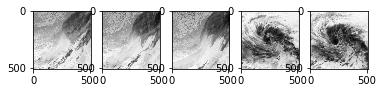

In [12]:
# Let's look at some sample images
# Warning: this may take a while initially and is prone to crashing. Execute
# at your own risk.

plt.figure(figsize=(10,10))
print("Sample data:")
fig, ax = plt.subplots(1,5)
for i in range(5):
  img = getImageFromH5(labels.loc[i])
  ax[i].imshow(img, cmap='gray')
plt.show()

In [13]:
# Labels of each row
list(labels.columns.values)

['sequence',
 'raw_index',
 'datetime',
 'class',
 'latitude',
 'longitude',
 'pressure',
 'TCxETC',
 'year',
 'month',
 'day']

Classes: [0 1 2 3 4 5]
Distribution 
0    42312
3    40694
1    36358
2    25703
4    18447
5      151
Name: class, dtype: int64


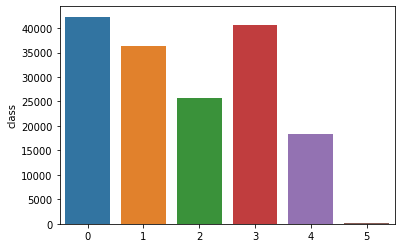

In [14]:
# Class
classes = np.sort(labels['class'].unique())
print("Classes:", classes)
print("Distribution ")
dist = labels['class'].value_counts()
print(dist)
sns.barplot(dist.index, dist)

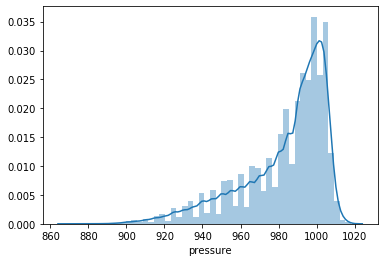

In [15]:
# Pressure distribution
pressure = labels['pressure']
sns.distplot(pressure)

In [16]:
# Pressure decile
decile = [.1, .2, .3, .4, .5, .6, .7, .8, .9]
cutoff = pressure.quantile(decile)
print("Median of each quantile")
print(cutoff)
qcutted = pd.qcut(pressure, 10, labels=False)
print("Number of image in each bin")
qcutted.value_counts().sort_index()

Median of each quantile
0.1     950.000000
0.2     965.000000
0.3     977.000000
0.4     985.000000
0.5     990.666667
0.6     995.000000
0.7     998.000000
0.8    1002.000000
0.9    1004.000000
Name: pressure, dtype: float64
Number of image in each bin


0    18833
1    14951
2    15325
3    19252
4    13710
5    16662
6    16263
7    20964
8    12134
9    15571
Name: pressure, dtype: int64

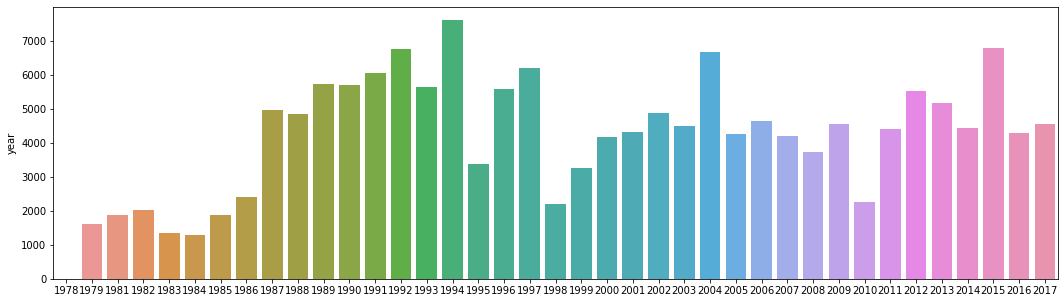

In [17]:
# By Year
years = labels['year']
count_years = years.value_counts()
plt.figure(figsize=(18,5))
sns.barplot(count_years.index, count_years)

#### Observations
There are some observations we made about the dataset.
* The images do not zoom closely to the TC and sometimes capture a nearby TC.
  * This is an issue with the data source.
  * We would bear with it for now and observe what is going to happen.
* There is a very obvious surplus of images of weaker TCs.
  * The weakest class has 1615 images, but the strongest 32 only.
  * We would bear with it for now and observe what is going to happen.
  * Potential solutions are: **(To be finalized)**
    * rotate some images to make up for the numbers, but the images would be similar
    * go further back and obtain images from before 2009, until there aren't even such satellite images available
    * for these stronger TCs, we include satellite images taken every (for example) 3 hours instead of 6, thereby getting more (but similar) images
    * check other sources for images, but the images would have different dimensions/zooming levels or may require other preprocessing

### Preprocessing

This part is rather straightforward. Based on the criteria stated above, we drop unnecessary columns and bin the pressure values into labels (just using numbers 1-12 should be ok). Next the dataset is separated into train, dev and test sets. After that each set gets its own PyTorch DataLoader pipeline.

In [18]:
# Import 
from sklearn.model_selection import train_test_split

In [19]:
# Pick useful label attributes only
processed_labels = labels[['class','sequence','raw_index','year']]

In [20]:
# To prevent Data leak, we seperate test data by year
train_ratio = 0.8
test_after_year = 2012
test_set = processed_labels[processed_labels['year'] >= 2012]
traindev_set = processed_labels[processed_labels['year'] < 2012]
train_set, dev_set = train_test_split(traindev_set, train_size=train_ratio, shuffle=True)
print(len(test_set),
len(train_set),
len(dev_set),)

30738 106341 26586


In [21]:
# Import pytorch and packages gonna use
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.nn as nn
import torch.optim as optim
from PIL import Image

In [37]:
""" Custom PyTorch Dataset """
class TyDataset(Dataset):
  def __init__(self, df, is_pretrain=False):
    self.df = df
    self.transform = transforms.Compose([
      transforms.Resize(224),      #This is for pre-trained model use
      transforms.CenterCrop(224),  
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.5], std=[0.5])
  ])
  
  def __len__(self):
    return len(self.df)
  
  def __getitem__(self, idx):
    img = getImageFromH5(self.df.iloc[idx])
    img = Image.fromarray(img).convert('RGB')
    label = self.df.iloc[idx]['class']
    image = self.transform(img)
    return image, label

### [Interim Prototype] Building and Training a Model - Take 1: Pre-trained Net

After the preprocessing is complete, a model is developed as baseline.

Firstly we try to use a pre-trained CNN "densenet161" and see how it performs with our data.

For loss function we chose cross entropy loss and optimizer is Adam.

In [60]:
""" Creating DataLoader instances """
# DataLoader for training set
train_batch_size = batch_size
train_ds = TyDataset(train_set)
train_loader = DataLoader(train_ds, batch_size = train_batch_size, shuffle=True, num_workers=16, drop_last=True, pin_memory=True)
print("Training set size (after DataLoader processing):", len(train_ds))

# DataLoader for dev set
dev_batch_size = batch_size
dev_ds = TyDataset(dev_set)
dev_loader = DataLoader(dev_ds, batch_size = dev_batch_size, shuffle=True, num_workers=16, drop_last=True, pin_memory=True)
print("Dev set size (after DataLoader processing):", len(dev_ds))

# DataLoader for test set
test_batch_size = batch_size
test_ds = TyDataset(test_set)
test_loader = DataLoader(test_ds, batch_size = test_batch_size, shuffle=True, num_workers=16, drop_last=True, pin_memory=True)
print("Training set size (after DataLoader processing):", len(test_ds))

Training set size (after DataLoader processing): 106341
Dev set size (after DataLoader processing): 26586
Training set size (after DataLoader processing): 30738


In [61]:
# DEBUG: Get one batch
# next(iter(train_loader))

In [62]:
class data_prefetcher():
    def __init__(self, loader):
        self.loader = iter(loader)
        self.stream = torch.cuda.Stream()
        self.mean = torch.tensor([0.485 * 255, 0.456 * 255, 0.406 * 255]).cuda().view(1,3,1,1)
        self.std = torch.tensor([0.229 * 255, 0.224 * 255, 0.225 * 255]).cuda().view(1,3,1,1)
        # With Amp, it isn't necessary to manually convert data to half.
        # if args.fp16:
        #     self.mean = self.mean.half()
        #     self.std = self.std.half()
        self.preload()

    def preload(self):
        try:
            self.next_input, self.next_target = next(self.loader)
        except StopIteration:
            self.next_input = None
            self.next_target = None
            return
        with torch.cuda.stream(self.stream):
            self.next_input = self.next_input.cuda(non_blocking=True)
            self.next_target = self.next_target.cuda(non_blocking=True)
            # With Amp, it isn't necessary to manually convert data to half.
            # if args.fp16:
            #     self.next_input = self.next_input.half()
            # else:
            
    def next(self):
        torch.cuda.current_stream().wait_stream(self.stream)
        input = self.next_input
        target = self.next_target
        self.preload()
        return input, target

In [63]:
# Get device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device:",device)
if not torch.cuda.is_available():
  print("Suggest you use GPU")

Device: cuda


In [64]:
""" Pre-trained CNN Model """
import torchvision.models as models

class interim_prototype_take1(nn.Module):
  def __init__(self):
    super(interim_prototype_take1, self).__init__()
    ## Define layers
    # Input shape: (Batch size, 1, 512, 512)
    # Convolution layer(s)
    self.conv = self.pretrained_model()
    # FC layer(s)
    self.fc = nn.Sequential(
          nn.Linear(1000, 512), # 1000 is the default output size in densenet
          nn.ReLU(),
          nn.Dropout(0.2),
          nn.Linear(512, 12)
        )
  
  def pretrained_model(self):
    model = models.densenet161(pretrained=True) 
    for param in model.parameters():
      param.requires_grad = False
    return model

  def forward(self, x):
    x = self.conv(x)
    x = self.fc(x)
    return x

# construct and pass to device
interim_model = interim_prototype_take1()
interim_model = interim_model.to(device)
# print("Interim prototype model structure: ")
# print(interim_model) 

In [65]:
# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizer
optimizer = optim.Adam(interim_model.parameters(), lr=learning_rate)

Now with the preparation complete, the following performs the training process.

In [66]:
# Function to train one epoch, adopted from Module 3 materials
def train_one_epoch(model, device, criterion, optimizer, dataloader):
  model.train()
  epoch_loss = 0.0
  correct_preds, total_preds = 0, 0

  for i, (images, target) in enumerate(dataloader):
    images = images.cuda(non_blocking=True)
    target = target.cuda(non_blocking=True)
    
    outputs = model.forward(images)
    
    loss = criterion(outputs, target)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    _, preds = torch.max(outputs.data, 1)
    correct_preds += (preds == target).sum().item()
    total_preds += target.size(0)
    epoch_loss += loss.item()

    if (i%20 == 0):
      print("# Batches Processed: ",i,"/",len(dataloader))

  log_dict = {}
  log_dict['loss'] = epoch_loss
  log_dict['acc'] = (100 * correct_preds/total_preds) #Fixed acc calculation here
  return log_dict

In [67]:
# Function for evaluation, modified from Module 3 materials
def eval_one_epoch(model, device, criterion, dataloader):
  model.eval()
  epoch_loss = 0.0
  correct_preds, total_preds = 0.0, 0.0

  for i, (images, labels) in enumerate(dataloader):
    images = images.to(device, non_blocking=True)
    labels = labels.to(device, non_blocking=True)
    with torch.no_grad():
      outputs = model(images)
    loss = criterion(outputs, labels)
    _, preds = torch.max(outputs.data, 1)
    correct_preds += (preds == labels).sum().item()
    total_preds += labels.size(0)
    epoch_loss += loss.item()
  
  log_dict = {}
  log_dict['loss'] = epoch_loss
  log_dict['acc'] = (100 * correct_preds/total_preds) #fixed
  return log_dict

In [ ]:
# Main training loop ahead
from time import time

all_train_acc, all_dev_acc = [], []
begin_time = time()
for epoch in range(n_epochs):
  print("Running epoch ",epoch,"/",n_epochs,":")
  print("====================")

  log_dict = train_one_epoch(interim_model, device=device, criterion=criterion, optimizer=optimizer, dataloader=train_loader)
  train_loss = log_dict['loss'] / len(train_loader)
  train_acc = log_dict['acc']
  all_train_acc.append(train_acc)

  log_dict = eval_one_epoch(interim_model, device=device, criterion=criterion, dataloader=dev_loader)
  dev_loss = log_dict['loss'] / len(dev_loader)
  dev_acc = log_dict['acc']
  all_dev_acc.append(dev_acc)

  finish_time = time()
  print("Time: ", finish_time-begin_time)
  print("----Training----")
  print("Loss: ", train_loss)
  print("Acc: ", train_acc)
  print("----Dev----")
  print("Loss: ", dev_loss)
  print("Acc: ", dev_acc)
  print("====================")

Running epoch  0 / 20 :
# Batches Processed:  0 / 3323
# Batches Processed:  20 / 3323
# Batches Processed:  40 / 3323
# Batches Processed:  60 / 3323
# Batches Processed:  80 / 3323
# Batches Processed:  100 / 3323
# Batches Processed:  120 / 3323
# Batches Processed:  140 / 3323


In [ ]:
# Model evaluation: benchmarking with test
log_dict = eval_one_epoch(interim_model, device, criterion, dataloader=test_loader)
test_loss = log_dict['loss']
test_acc = log_dict['acc']
print("Test results:")
print("====================")
print("Loss: ", test_loss)
print("Acc: ", test_acc)
print("Try harder!")
print("====================")

Test results:
Loss:  103.57962131500244
Acc:  28.879310344827587
Try harder!


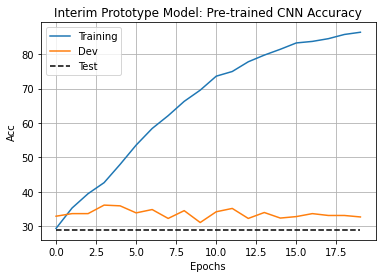

In [ ]:
# Some visualization code
fig, ax = plt.subplots()
plt.title("Interim Prototype Model: Pre-trained CNN Accuracy")
ax.plot(all_train_acc, label="Training")
ax.plot(all_dev_acc, label="Dev")
plt.hlines(test_acc, xmin=0, xmax=n_epochs-1, label="Test", linestyles='dashed')

plt.grid()
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend(loc='upper left')
plt.show()

The following are obtained from the first successful (i.e. no runtime error) test run of the said model:

||Training|Dev|Test|
---|---|---|---
Acc:| 0.001 | 0.002 | 0.0018

Running time: 1745s = ca. 29 minutes

![Image: performance plot](https://drive.google.com/uc?id=1bRPjaNC97slYTRQZ6wNJHt5GdhO9YaMV)

The performance is not satisfactory at all. We assumed that the pre-trained model is trained on RGB images of other uses/sources, therefore it does not adapt well, if at all, to this new situation. 

However, after fixing an issue with accuracy calculation, the performance improved greatly, except we observe overfitting:

||Training|Dev|Test|
---|---|---|---
Acc:| 85.829 | 31.034 | 30.388

Running time: 2181s = ca. 36 minutes

![alt text](https://drive.google.com/uc?id=14tvApO6KbhSAcDUdzYUD7ZOvtQMQw-Qx)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Batches evaluated:  0 / 232
# Batches evaluated:  20 / 232
# Batches evaluated:  40 / 232
# Batches evaluated:  60 / 232
# Batches evaluated:  80 / 232
# Batches evaluated:  100 / 232
# Batches evaluated:  120 / 232
# Batches evaluated:  140 / 232
# Batches evaluated:  160 / 232
# Batches evaluated:  180 / 232
# Batches evaluated:  200 / 232
# Batches evaluated:  220 / 232
Shapes: torch.Size([7424]) ; torch.Size([7424])


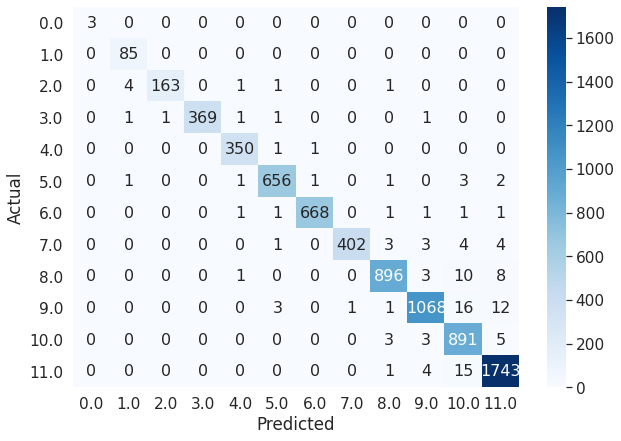

In [ ]:
""" Visualization: Confusion Matrix with training data """
import seaborn as sn
from sklearn.metrics import confusion_matrix

def get_all_preds(model, loader, device):
  all_preds = []
  all_labels = []
  with torch.no_grad():
    for i, (images, labels) in enumerate(loader):
      images, labels = images.to(device), labels.to(device)
      output = model(images)
      preds = torch.argmax(output.data, 1)
      all_preds.extend(preds) #torch.cat((all_preds, preds), dim=0)
      all_labels.extend(labels)# = torch.cat((all_labels, labels), dim=0)
      if (i%20 == 0):
        print("# Batches evaluated: ",i,"/",len(loader))
  return all_preds, all_labels

train_preds, train_truth = get_all_preds(interim_model, train_loader, device)
train_preds, train_truth = torch.FloatTensor(train_preds), torch.FloatTensor(train_truth)
print("Shapes:",train_preds.size(),";",train_truth.size())
data = confusion_matrix(train_truth, train_preds)
df_cm = pd.DataFrame(data, columns=np.unique(train_truth), index = np.unique(train_truth))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sn.set(font_scale=1.4)
sn.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16}, fmt='d')

# Batches evaluated:  0 / 29
# Batches evaluated:  20 / 29
Shapes: torch.Size([928]) ; torch.Size([928])


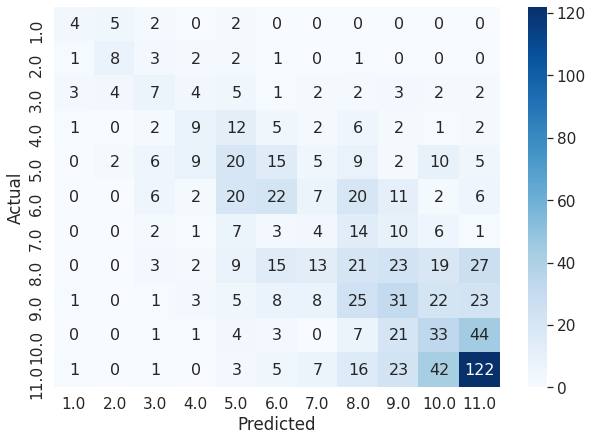

In [ ]:
""" Visualization: Confusion Matrix with Test Set"""
test_preds, test_truth = get_all_preds(interim_model, test_loader, device)
test_preds, test_truth = torch.FloatTensor(test_preds), torch.FloatTensor(test_truth)
print("Shapes:",test_preds.size(),";",test_truth.size())
data = confusion_matrix(test_truth, test_preds)
df_cm = pd.DataFrame(data, columns=np.unique(test_truth), index = np.unique(test_truth))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sn.set(font_scale=1.4)
sn.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16}, fmt='d')

### [Interim Prototype] Building and Training a Model - Take 2: Custom CNN

This time, we construct our own model from scratch. The structure is as follows:
* Conv2D with 16 filters and kernel size 3, followed by a ReLU
* Conv2D with 16 filters and kernel size 3, followed by a ReLU, average pooling (kernel size 2) and dropout (0.2)
* Conv2D with 16 filters and kernel size 3, followed by a ReLU, average pooling (kernel size 2) and dropout (0.2)
* Conv2D with 16 filters and kernel size 3, followed by a ReLU, average pooling (kernel size 2) and dropout (0.2)
* Flattening and Linear layer (65536 neurons -> 4096) with ReLU and dropout (0.2)
* Linear (4096 -> 1024) with ReLU
* Linear (1024 -> 32) with Sigmoid

For optimizer and loss function choices, we stick to Adam and Cross Entropy respectively as before.

In [ ]:
""" Reused code """
# Get device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device:",device)
if not torch.cuda.is_available():
  print("Suggest you use GPU")

Device: cuda


In [ ]:
# DataLoader for training set
train_batch_size = batch_size
train_ds = TyDataset(train_set)
train_loader = DataLoader(train_ds, batch_size = train_batch_size, shuffle=True, num_workers=8, drop_last=True)
print("Training set size (after DataLoader processing):", len(train_ds))

# DataLoader for dev set
dev_batch_size = batch_size
dev_ds = TyDataset(dev_set)
dev_loader = DataLoader(dev_ds, batch_size = dev_batch_size, shuffle=True, num_workers=8, drop_last=True)
print("Dev set size (after DataLoader processing):", len(dev_ds))

# DataLoader for test set
test_batch_size = batch_size
test_ds = TyDataset(test_set)
test_loader = DataLoader(test_ds, batch_size = test_batch_size, shuffle=True, num_workers=8, drop_last=True)
print("Training set size (after DataLoader processing):", len(test_ds))

Training set size (after DataLoader processing): 7453
Dev set size (after DataLoader processing): 933
Training set size (after DataLoader processing): 931


In [ ]:
""" New Model """

class interim_prototype_take2(nn.Module):
  def __init__(self):
    super(interim_prototype_take2, self).__init__()
    # CNN Model layers
    # Input shape: Batch size B, 1 channel, 512, 512
    
    # conv. layers
    # uncomment to use
    self.conv = nn.Sequential(
        # After 1st conv: (B, 1, 512, 512) -> (B, 16, 512, 512)
        nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1, bias=False),
        nn.ReLU(True),
        # After 2nd conv: (B, 16, 512, 512) -> (B, 16, 512, 512)
        nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=1, bias=False),
        nn.ReLU(True),
        # After AvgPool2d: (B, 16, 512, 512) -> (B, 16, 256, 256)
        nn.AvgPool2d(kernel_size=2),  #stride = 1?
        nn.Dropout(0.20),
        # After 3rd conv: (B, 16, 256, 256) -> (B, 16, 256, 256)
        nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=1, bias=False),
        nn.ReLU(True),
        # After AvgPool2d: (B, 16, 256, 256) -> (B, 16, 128, 128)
        nn.AvgPool2d(kernel_size=2),
        nn.Dropout(0.20),
        # After 4th conv: (B, 16, 128, 128) -> (B, 16, 128, 128)
        nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=1, bias=False),
        nn.ReLU(True),
        # After AvgPool2d: (B, 16, 128, 128) -> (B, 16, 64, 64)
        nn.AvgPool2d(kernel_size=2),
        nn.Dropout(0.20),
    )

    # The following is the version of the conv. layers used to ease visualization
    # and is essentially identical as above. However, this somehow crashes the accuracy.
    '''self.conv1 = nn.Sequential(
        nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1, bias=False),
        nn.ReLU(True),
    )
    self.conv2 = nn.Sequential(
        nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=1, bias=False),
        nn.ReLU(True),
        nn.AvgPool2d(kernel_size=2),
        nn.Dropout(0.20),
    )
    self.conv3 = nn.Sequential(
        nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=1, bias=False),
        nn.ReLU(True),
        nn.AvgPool2d(kernel_size=2),
        nn.Dropout(0.20),
    )
    self.conv4 = nn.Sequential(
        nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=1, bias=False),
        nn.ReLU(True),
        nn.AvgPool2d(kernel_size=2),
        nn.Dropout(0.20),
    )'''

    # FC layers
    self.fc = nn.Sequential(
        # After flattening: (B, 16, 64, 64) -> (B, 16*64*64) (65,536 neurons)
        nn.Flatten(),
        nn.Linear(16*64*64,1024),
        nn.ReLU(True),
        nn.Dropout(0.20),
        nn.Linear(1024, 12), #fix output shape to (B, B)
        #nn.Sigmoid(), #potentially problematic
    )
  
  def forward(self,x):
    x = self.conv(x)
    '''self.x1 = self.conv1(x)       #added code to save intermediate result
    self.x2 = self.conv2(self.x1)
    self.x3 = self.conv3(self.x2)
    self.x4 = self.conv4(self.x3)
    self.x5 = self.fc(self.x4)'''
    x = self.fc(x)
    return x

interim_model_1 = interim_prototype_take2()
interim_model_1 = interim_model_1.to(device)
print("New model structure:")
print(interim_model_1)

New model structure:
interim_prototype_take2(
  (conv): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): ReLU(inplace=True)
    (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (3): ReLU(inplace=True)
    (4): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (5): Dropout(p=0.2, inplace=False)
    (6): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (7): ReLU(inplace=True)
    (8): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (9): Dropout(p=0.2, inplace=False)
    (10): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (11): ReLU(inplace=True)
    (12): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (13): Dropout(p=0.2, inplace=False)
  )
  (fc): Sequential(
    (0): Flatten()
    (1): Linear(in_features=65536, out_features=1024, bias=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.2, inplace=False)
    (4): Lin

In [ ]:
""" Reused """
# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizer
optimizer = optim.Adam(interim_model_1.parameters(), lr=learning_rate)

In [ ]:
""" Slightly adjusted train_one_epoch code"""
def train_one_epoch(model, device, criterion, optimizer, dataloader):
  model.train()
  epoch_loss = 0.0
  correct_preds, total_preds = 0.0, 0.0

  for i, (images, labels) in enumerate(dataloader):
    images, labels = images.to(device), labels.to(device)
    optimizer.zero_grad()
    outputs = model.forward(images)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    _, preds = torch.max(outputs.data, 1)
    correct_preds += (preds == labels).sum().item()
    total_preds += labels.size(0)
    epoch_loss += loss.item()
    if (i%20 == 0):
      print("# Batches Processed: ",i,"/",len(dataloader))
  
  log_dict = {}
  log_dict['loss'] = epoch_loss
  log_dict['acc'] = (100 * correct_preds/total_preds)
  return log_dict

  """ Do execute the cell containing eval_one_epoch again """

In [ ]:
""" Reused: Training loop """
from time import time

all_train_acc, all_dev_acc = [], []
begin_time = time()
for epoch in range(n_epochs):
  print("Running epoch ",epoch,"/",n_epochs,":")
  print("====================")

  log_dict = train_one_epoch(interim_model_1, device=device, criterion=criterion, optimizer=optimizer, dataloader=train_loader)
  train_loss = log_dict['loss'] / len(train_loader)
  train_acc = log_dict['acc']
  all_train_acc.append(train_acc)

  log_dict = eval_one_epoch(interim_model_1, device=device, criterion=criterion, dataloader=dev_loader)
  dev_loss = log_dict['loss'] / len(dev_loader)
  dev_acc = log_dict['acc']
  all_dev_acc.append(dev_acc)

  finish_time = time()
  print("Time: ", finish_time-begin_time)
  print("----Training----")
  print("Loss: ", train_loss)
  print("Acc: ", train_acc)
  print("----Dev----")
  print("Loss: ", dev_loss)
  print("Acc: ", dev_acc)
  print("====================")

Running epoch  0 / 20 :
# Batches Processed:  0 / 232
# Batches Processed:  20 / 232
# Batches Processed:  40 / 232
# Batches Processed:  60 / 232
# Batches Processed:  80 / 232
# Batches Processed:  100 / 232
# Batches Processed:  120 / 232
# Batches Processed:  140 / 232
# Batches Processed:  160 / 232
# Batches Processed:  180 / 232
# Batches Processed:  200 / 232
# Batches Processed:  220 / 232
Time:  52.94151592254639
----Training----
Loss:  2.4837571947739043
Acc:  14.601293103448276
----Dev----
Loss:  2.484197057526687
Acc:  14.224137931034482
Running epoch  1 / 20 :
# Batches Processed:  0 / 232
# Batches Processed:  20 / 232
# Batches Processed:  40 / 232
# Batches Processed:  60 / 232
# Batches Processed:  80 / 232
# Batches Processed:  100 / 232
# Batches Processed:  120 / 232
# Batches Processed:  140 / 232
# Batches Processed:  160 / 232
# Batches Processed:  180 / 232
# Batches Processed:  200 / 232
# Batches Processed:  220 / 232
Time:  105.83424210548401
----Training---

In [ ]:
""" Reused: Evaluation """
log_dict = eval_one_epoch(interim_model_1, device, criterion, dataloader=test_loader)
test_loss = log_dict['loss']
test_acc = log_dict['acc']
print("Test results:")
print("====================")
print("Loss: ", test_loss)
print("Acc: ", test_acc)
print("Is this better than before?")
print("====================")

The following are obtained from a run on 18th April, without the sigmoid:

||Training|Dev|Test|
---|---|---|---
Acc:| 99.232 | 29.418 | 26.616

Running time: 1630s ~= 27 minutes. Below are code to visualize the model's performance. Some plots on 18 April, during the development of an interim prototype are as follows:

Accuracy against epoch:

![alt text](https://drive.google.com/uc?id=1xzzGNCI5p3CSlL8zr4sj5SCfjF86OqRE)

Confusion matrix with training set:

![alt text](https://drive.google.com/uc?id=1-_N4JtQRbe4Arwi2jqgs61iAxms1enKA)

Confusion matrix with testing set:

![alt text](https://drive.google.com/uc?id=1tAYiB30VnzweryEvAHDbfMSmKnFZPH-E)

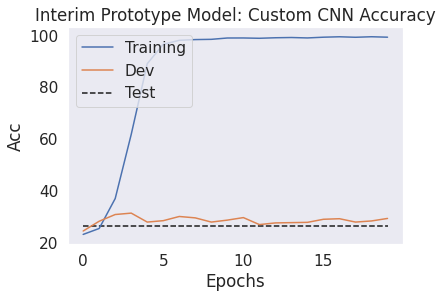

In [ ]:
""" Visualization: Accuracy over epoch graph """
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots()
plt.title("Interim Prototype Model: Custom CNN Accuracy")
ax.plot(all_train_acc, label="Training")
ax.plot(all_dev_acc, label="Dev")
plt.hlines(test_acc, xmin=0, xmax=n_epochs-1, label="Test", linestyles='dashed')

plt.grid()
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend(loc='upper left')
plt.show()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Batches evaluated:  0 / 232
# Batches evaluated:  20 / 232
# Batches evaluated:  40 / 232
# Batches evaluated:  60 / 232
# Batches evaluated:  80 / 232
# Batches evaluated:  100 / 232
# Batches evaluated:  120 / 232
# Batches evaluated:  140 / 232
# Batches evaluated:  160 / 232
# Batches evaluated:  180 / 232
# Batches evaluated:  200 / 232
# Batches evaluated:  220 / 232
Shapes: torch.Size([7424]) ; torch.Size([7424])


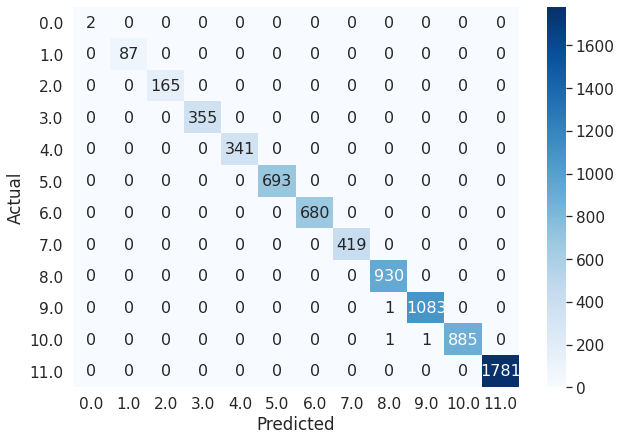

In [ ]:
""" Visualization: Confusion Matrix with training data """
# Adapted from https://www.kaggle.com/agungor2/various-confusion-matrix-plots
import seaborn as sn
from sklearn.metrics import confusion_matrix

def get_all_preds(model, loader, device):
  all_preds = []
  all_labels = []
  model.eval()
  with torch.no_grad():
    for i, (images, labels) in enumerate(loader):
      images, labels = images.to(device), labels.to(device)
      output = model(images)
      preds = torch.argmax(output.data, 1)
      all_preds.extend(preds) #torch.cat((all_preds, preds), dim=0)
      all_labels.extend(labels)# = torch.cat((all_labels, labels), dim=0)
      if (i%20 == 0):
        print("# Batches evaluated: ",i,"/",len(loader))
  return all_preds, all_labels

train_preds, train_truth = get_all_preds(interim_model_1, train_loader, device)
train_preds, train_truth = torch.FloatTensor(train_preds), torch.FloatTensor(train_truth)
print("Shapes:",train_preds.size(),";",train_truth.size())
data = confusion_matrix(train_truth, train_preds)
df_cm = pd.DataFrame(data, columns=np.unique(train_truth), index = np.unique(train_truth))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sn.set(font_scale=1.4)
sn.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16}, fmt='d')

# Batches evaluated:  0 / 29
# Batches evaluated:  20 / 29
Shapes: torch.Size([928]) ; torch.Size([928])


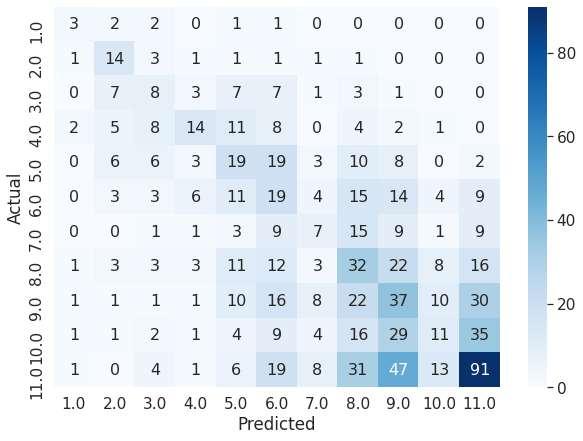

In [ ]:
""" Visualization: Confusion Matrix with Test Set"""
test_preds, test_truth = get_all_preds(interim_model_1, test_loader, device)
test_preds, test_truth = torch.FloatTensor(test_preds), torch.FloatTensor(test_truth)
print("Shapes:",test_preds.size(),";",test_truth.size())
data = confusion_matrix(test_truth, test_preds)
df_cm = pd.DataFrame(data, columns=np.unique(test_truth), index = np.unique(test_truth))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sn.set(font_scale=1.4)
sn.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16}, fmt='d')

### [Interim Prototype] Conclusions about the two models

Both models have shown overfitting to the training data and yielded similar results when they were evaluated with the test set. We hypothesize that they have overfitted and failed to extract the key features from the images, leading to ridiculous results.

There are many ways that we can improve the outcome. In the upcoming week (since 20 April), we would soon be granted access to Prof. Kitamoto's dataset, which may provide useful insights; in addition thereto, visualizing the convolution network weights, introducing cross validation and modifying model architecture (esp. its depth, dropout rate and choice of activation functions) are also viable ways to improve.

### Demo of current model

Lets give a typhoon picture to our current model to see how the models perform!


Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.6/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['shuffle', 'time']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


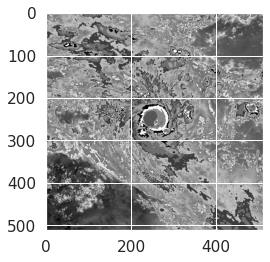

In [ ]:
from PIL import Image
import requests
from io import BytesIO
%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


response = requests.get('http://agora.ex.nii.ac.jp/digital-typhoon/wsp/by-name/201822/bd/512x512/HMW818032312.201822.jpg')
img = Image.open(BytesIO(response.content))
imgplot = plt.imshow(img, cmap='gray')
plt.show()

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor()
    ]
)
t = transform(img).unsqueeze(0).cuda()
with torch.no_grad():
  outputs = interim_model_1(t)
  _, predicted = torch.max(outputs.data, 1)
  print(predicted)
  

tensor([11], device='cuda:0')


In [ ]:
transform = transforms.Compose([
      transforms.Resize(256),
      transforms.CenterCrop(224),  
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
  ])

t = transform(img.convert('RGB')).unsqueeze(0).cuda()

with torch.no_grad():
  outputs = interim_model(t)
  _, predicted = torch.max(outputs.data, 1)
  print(predicted)

tensor([1], device='cuda:0')


## Error Analysis

After obtaining the results above, we decided to start tackling with the issue that there is an outrageously wide gap between train and dev/test accuracies. The first thing we tried was to visualize CNN convolution results.

### Feature map visualization

To implement the code that makes visualization work, the model itself has to be edited a bit, such that `torch.nn.Sequential` is not used to wrap the  convolution layers in one and intermediate layers are accessible.

16


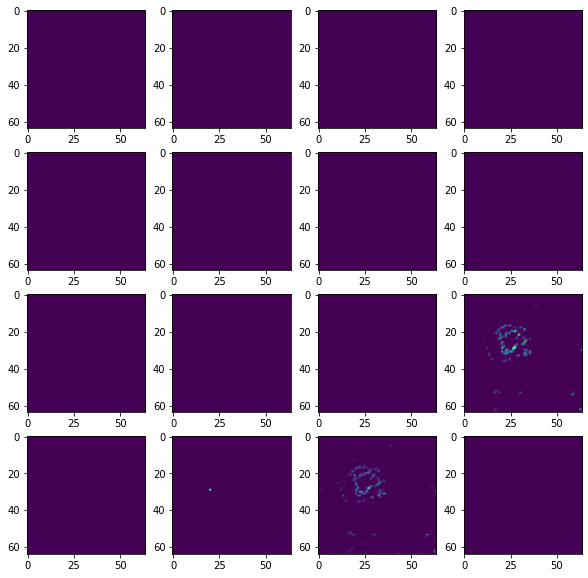

In [ ]:
""" 
Visualizing conv feature maps with PyTorch
Code modified from https://discuss.pytorch.org/t/visualize-feature-map/29597/2
See also: https://github.com/utkuozbulak/pytorch-cnn-visualizations/blob/master/src/cnn_layer_visualization.py
"""

# Visualize activations
activation = {}
def get_activation(name):
  def hook(model, input, output):
    activation[name] = output.detach()
  return hook

# access intermediate layers: remove last 4 layers of conv part
#module = nn.Sequential(*list(test_model.conv.children())[:-4])

test_model.conv.register_forward_hook(get_activation('conv'))
data, _ = next(iter(test_loader)) #obtain random image from dataloader
data = data[0]
data.unsqueeze_(0)
model_cpu = test_model.cpu()
output = model_cpu(data)  # it handles a batch each time...

act = activation['conv'].squeeze() 
print(act.size(0))
fig, axarr = plt.subplots(4,4, figsize=(10,10))
for i in range(4):
  for j in range(4):
    axarr[i][j].imshow(act[i*4+j])

### Training-Dev set

The second thing we tried was to add a training-dev set and observe the model's behaviour. A bit of L2 regulatization is also introduced at this point.

In [ ]:
""" Creating four datasets """
dataset = shuffle(dataset)
train_set_ratio = 0.8
dev_set_ratio = 0.1
test_dev_ratio = 0.1

temp, test_set = train_test_split(dataset, test_size = 1 - train_set_ratio)
test_set, dev_set = train_test_split(test_set, test_size = dev_set_ratio/(1-train_set_ratio))
train_set, train_dev_set = train_test_split(temp, test_size = test_dev_ratio/(train_set_ratio))

print("train set:")
train_set.info()
print("train-dev set:")
train_dev_set.info()
print("dev set:")
dev_set.info()
print("test set:")
test_set.info()

train set:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 6521 entries, 5876 to 6441
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   img     6521 non-null   object  
 1   labels  6521 non-null   category
dtypes: category(1), object(1)
memory usage: 108.7+ KB
train-dev set:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 932 entries, 8968 to 6014
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   img     932 non-null    object  
 1   labels  932 non-null    category
dtypes: category(1), object(1)
memory usage: 15.9+ KB
dev set:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 933 entries, 1953 to 917
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   img     933 non-null    object  
 1   labels  933 non-null    category
dtypes: category(1), object(1)
memory usage: 15.9+ KB
test set:
<class 'pand

In [ ]:
""" Dataset and DataLoader """
# DataLoader for training set
train_batch_size = batch_size
train_ds = TyDataset(train_set)
train_loader = DataLoader(train_ds, batch_size = train_batch_size, shuffle=True, num_workers=8, drop_last=True)
print("Training set size (after DataLoader processing):", len(train_ds))

# DataLoader for training-dev set
train_dev_batch_size = batch_size
train_dev_ds = TyDataset(train_dev_set)
train_dev_loader = DataLoader(train_dev_ds, batch_size = train_dev_batch_size, shuffle=True, num_workers=8, drop_last=True)
print("Training-dev set size (after DataLoader processing):", len(train_dev_ds))

# DataLoader for dev set
dev_batch_size = batch_size
dev_ds = TyDataset(dev_set)
dev_loader = DataLoader(dev_ds, batch_size = dev_batch_size, shuffle=True, num_workers=8, drop_last=True)
print("Dev set size (after DataLoader processing):", len(dev_ds))

# DataLoader for test set
test_batch_size = batch_size
test_ds = TyDataset(test_set)
test_loader = DataLoader(test_ds, batch_size = test_batch_size, shuffle=True, num_workers=8, drop_last=True)
print("Training set size (after DataLoader processing):", len(test_ds))

Training set size (after DataLoader processing): 6521
Training-dev set size (after DataLoader processing): 932
Dev set size (after DataLoader processing): 933
Training set size (after DataLoader processing): 931


In [ ]:
""" Device, Criterion and Other Stuff """
# Get device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device:",device)
if not torch.cuda.is_available():
  print("Suggest you use GPU")

# Get model
test_model = interim_prototype_take2()
test_model = test_model.to(device)
print(test_model)

# Criterion and Optimizer
L2_decay = 0.001  #set up L2 regularization
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(test_model.parameters(), lr=learning_rate, weight_decay=L2_decay)

Device: cuda
interim_prototype_take2(
  (conv): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): ReLU(inplace=True)
    (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (3): ReLU(inplace=True)
    (4): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (5): Dropout(p=0.2, inplace=False)
    (6): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (7): ReLU(inplace=True)
    (8): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (9): Dropout(p=0.2, inplace=False)
    (10): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (11): ReLU(inplace=True)
    (12): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (13): Dropout(p=0.2, inplace=False)
  )
  (fc): Sequential(
    (0): Flatten()
    (1): Linear(in_features=65536, out_features=1024, bias=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_f

In [ ]:
""" Modified training loop, with test set evaluation included """
from time import time

all_train_acc, all_td_acc, all_dev_acc = [], [], []
begin_time = time()
for epoch in range(n_epochs):
  print("Running epoch ",epoch,"/",n_epochs,":")
  print("====================")

  log_dict = train_one_epoch(test_model, device=device, criterion=criterion, optimizer=optimizer, dataloader=train_loader)
  train_loss = log_dict['loss'] / len(train_loader)
  train_acc = log_dict['acc']
  all_train_acc.append(train_acc)

  log_dict = eval_one_epoch(test_model, device=device, criterion=criterion, dataloader=train_dev_loader)
  td_loss = log_dict['loss'] / len(train_dev_loader)
  td_acc = log_dict['acc']
  all_td_acc.append(td_acc)

  log_dict = eval_one_epoch(test_model, device=device, criterion=criterion, dataloader=dev_loader)
  dev_loss = log_dict['loss'] / len(dev_loader)
  dev_acc = log_dict['acc']
  all_dev_acc.append(dev_acc)

  finish_time = time()
  print("Time: ", finish_time-begin_time)
  print("---- Training ----")
  print("Loss: ", train_loss)
  print("Acc: ", train_acc)
  print("---- Training-Dev ----")
  print("Loss: ", td_loss)
  print("Acc: ", td_acc)
  print("----Dev----")
  print("Loss: ", dev_loss)
  print("Acc: ", dev_acc)
  print("====================")

Running epoch  0 / 20 :
# Batches Processed:  0 / 203
# Batches Processed:  20 / 203
# Batches Processed:  40 / 203
# Batches Processed:  60 / 203
# Batches Processed:  80 / 203
# Batches Processed:  100 / 203
# Batches Processed:  120 / 203
# Batches Processed:  140 / 203
# Batches Processed:  160 / 203
# Batches Processed:  180 / 203
# Batches Processed:  200 / 203
Time:  54.3019585609436
---- Training ----
Loss:  2.196978768104403
Acc:  22.9064039408867
---- Training-Dev ----
Loss:  2.1900416407091865
Acc:  23.16810344827586
----Dev----
Loss:  2.193347010119208
Acc:  23.49137931034483
Running epoch  1 / 20 :
# Batches Processed:  0 / 203
# Batches Processed:  20 / 203
# Batches Processed:  40 / 203
# Batches Processed:  60 / 203
# Batches Processed:  80 / 203
# Batches Processed:  100 / 203
# Batches Processed:  120 / 203
# Batches Processed:  140 / 203
# Batches Processed:  160 / 203
# Batches Processed:  180 / 203
# Batches Processed:  200 / 203
Time:  108.01672863960266
---- Trai

In [ ]:
log_dict = eval_one_epoch(test_model, device, criterion, dataloader=test_loader)
test_loss = log_dict['loss']
test_acc = log_dict['acc']
print("Test results:")
print("====================")
print("Loss: ", test_loss)
print("Acc: ", test_acc)
print("Behold!")
print("====================")

Test results:
Loss:  97.63326644897461
Acc:  26.07758620689655
Behold!


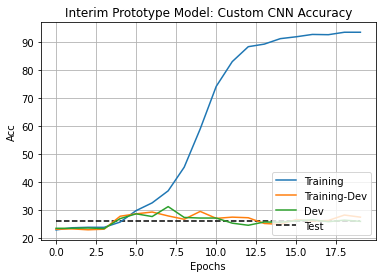

In [ ]:
""" Visualization: Accuracies against time """
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots()
plt.title("Interim Prototype Model: Custom CNN Accuracy")
ax.plot(all_train_acc, label="Training")
ax.plot(all_td_acc, label="Training-Dev")
ax.plot(all_dev_acc, label="Dev")
plt.hlines(test_acc, xmin=0, xmax=n_epochs-1, label="Test", linestyles='dashed')

plt.grid()
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend(loc='lower right')
plt.show()

Results (accuracy scores) from the first run of the above code on 24 April:

Training|Training-Dev|Dev|Test
---|---|---|---
93.657|27.478|25.969|26.077

![alt text](https://drive.google.com/uc?id=1WhJoDwZyQIr0m_aC3Y1qbgm7GU70L9GH)

Needless to say, this is exact proof that the model is overfitting to the training set, even with a bit of L2 regularization introduced. There are many ways we can handle it, googling for 30 seconds gave us:

* **Using more data**: 
  It happens that Prof. Kitamoto has replied on 23 April, giving us access to his 40GB large dataset. Although the image has a different representation (exact cloud top temperatures instead of colour-enhanced infrared image), this should not be a big deal, as Prof. Kitamoto is also worried that learning BD images might be difficult. Whatever the case, we now have access to a gigantic dataset, so extra data is secured.
* **Data augmentation**:
  This can be used to add more variation to the images, but we would see whether we can make do with Prof. Kitamoto's dataset first.
* **Regularization**:
  We have included numerous dropout layers in the model, but the Internet suggests gradually increasing dropout rate as we near the output layer, so it may be worth a try. In addition, regularization rates can be increased. But this latter option might be taken into consideration when we finally figure out how to do grid search.


---

In [ ]:
""" For CV later """
from skorch import NeuralNetClassifier
from skorch.dataset import CVSplit
from sklearn.model_selection import GridSearchCV, cross_val_score

begin_time = time()
test_net = NeuralNetClassifier(
    # PyTorch model
    module = interim_model_1,
    max_epochs = n_epochs,
    lr = learning_rate,
    device = 'cuda',
    criterion = nn.CrossEntropyLoss,
    optimizer = optim.Adam,
    optimizer__lr = learning_rate,
    batch_size = batch_size,
    # internal train/validation split by skorch
    # use pytorch dataset is ok, auto-wrapped
    # here validated against dev set
    train_split = predefined_split(dev_ds), 
)

# Directly fitting the model
test_net.fit(train_ds)
finish_time = time()

# Test set validate
test_score = test_net.score(test_ds)
print("Raw test accuracy: ", test_score)
# 5-fold CV scores
cv_scores = cross_val_score(test_net, train_ds, cv=5, scoring='accuracy')
print("5-Fold CV scores: ", cv_scores)
print("Mean: ", cv_scores.mean())